# Post Processing Glove Vectors
- The Glove Vectors are post processed according to the algorithm given in the paper https://arxiv.org/pdf/1702.01417.pdf
- Several benchmark datasets from https://github.com/kudkudak/word-embeddings-benchmarks are used to check the performance of the processsed vectors.
- The datasets are related to different tasks of similarity, analogy and categorisation. 

In [42]:
import numpy as np
import io
import zipfile

from sklearn.decomposition import PCA

from web.analogy import fetch_google_analogy, fetch_msr_analogy
from web.embedding import Embedding
from web.evaluate import evaluate_analogy, evaluate_on_all
from web.vocabulary import Vocabulary

import pandas as pd
import random
import os
import time
import numpy as np

def set_seed(seed):
    """Set seed"""
    random.seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)

set_seed(2020) # for reproducibility of random modules if used



In [15]:
def load_glove_embeddings(zip_path, dim=300):
    words = []
    embedding_matrix = []
    with zipfile.ZipFile(zip_path) as zip_file:
        with zip_file.open('glove.6B.{}d.txt'.format(dim), 'r') as file:
            file = io.TextIOWrapper(file)
            for line in file:
                line_split = line.split()
                word, vector = line_split[0], np.array(line_split[1:], dtype='float64')
                words.append(word)
                embedding_matrix.append(vector)
    embedding_matrix = np.stack(embedding_matrix)
    return words, embedding_matrix

## Algorithm to process the embeddings

In [16]:
def process_embeddings(embedding_matrix, D, inplace=False):
    if not inplace:
        embedding_matrix = embedding_matrix.copy()
    embedding_matrix = embedding_matrix - embedding_matrix.mean(axis=0)
    
    pca = PCA()
    pca = pca.fit(embedding_matrix)
    #I think this is  the step where the algorithm has typos. We need to use v_bar instead of v 
    coeffs = np.matmul(embedding_matrix, pca.components_[:D].T)
    embedding_matrix = embedding_matrix - np.matmul(coeffs, pca.components_[:D])
    return embedding_matrix

## Evaluating the performance of both embeddings on different tasks
- Categorisation tasks : **AP** , **BLESS** ,**Battig** ,**ESSLI_2c**, **ESSLI_2b**, **ESSLI_1a**
- Analogy tasks : **Google**, **MSR**, **SemEval2012_2**
- Word Similarity tasks: **MEN**, **WS353**, **WS353R**, **WS353S**, **SimLex999**, **RW**, **RG65**, **MTurk**

In [4]:
 words, embedding_matrix = load_glove_embeddings(zip_path='glove.6B.zip', dim=300)

In [5]:
glove_embeddings = Embedding(vocabulary=Vocabulary(words), vectors=embedding_matrix)
glove_analogy_results = evaluate_on_all(glove_embeddings)

/home/mila/g/gampapha/nlmatics_2/nlmatics/web/evaluate.py:336: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  A = np.vstack(w.get(word, mean_vector) for word in X[:, 0])
/home/mila/g/gampapha/nlmatics_2/nlmatics/web/evaluate.py:337: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  B = np.vstack(w.get(word, mean_vector) for word in X[:, 1])
Missing 24 words. Will replace them with mean vector
Missing 16 words. Will replace them with mean vector
Missing 11 words. Will replace them with mean vector
Missing 260 words. Will replace them with mean vector
/home/mila/g/gampapha/nlmatics_2/nlmatics/web/analogy.py:105: FutureWarning: arrays to stack must be passed a

In [6]:
processed_embedding_matrix = process_embeddings(embedding_matrix, D=2, inplace=False)

In [7]:
processed_embeddings = Embedding(vocabulary=Vocabulary(words), vectors=processed_embedding_matrix)
processed_analogy_results = evaluate_on_all(processed_embeddings)

/home/mila/g/gampapha/nlmatics_2/nlmatics/web/evaluate.py:336: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  A = np.vstack(w.get(word, mean_vector) for word in X[:, 0])
/home/mila/g/gampapha/nlmatics_2/nlmatics/web/evaluate.py:337: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  B = np.vstack(w.get(word, mean_vector) for word in X[:, 1])
Missing 24 words. Will replace them with mean vector
Missing 16 words. Will replace them with mean vector
Missing 11 words. Will replace them with mean vector
Missing 260 words. Will replace them with mean vector
/home/mila/g/gampapha/nlmatics_2/nlmatics/web/analogy.py:105: FutureWarning: arrays to stack must be passed a

In [8]:
glove_analogy_results

,AP,BLESS,Battig,ESSLI_2c,ESSLI_2b,ESSLI_1a,MEN,WS353,WS353R,WS353S,SimLex999,RW,RG65,MTurk,Google,MSR,SemEval2012_2
0,0.629353,0.795,0.408144,0.6,0.825,0.75,0.737465,0.543326,0.477487,0.661995,0.3705,0.367045,0.769525,0.633182,0.650993,0.514125,0.151804


In [9]:
processed_analogy_results

,AP,BLESS,Battig,ESSLI_2c,ESSLI_2b,ESSLI_1a,MEN,WS353,WS353R,WS353S,SimLex999,RW,RG65,MTurk,Google,MSR,SemEval2012_2
0,0.614428,0.78,0.416555,0.6,0.75,0.75,0.754177,0.571465,0.511425,0.679432,0.389328,0.343098,0.765722,0.641538,0.641066,0.4745,0.144469


# Results
- For the analogy tasks, **original** word embeddings perform better than the processed vectors. (Maybe because glove embeddings are trained using the co-occurance ratios directly which is highly similar to analogy task)
- For the similarity tasks, **processed** word embeddings perform better than the original vectors.
- For the categorisation tasks, **original** word embeddings perform better than the processed vectors. 

In [10]:
import matplotlib.pyplot as plt
from sklearn import preprocessing

pca1 = PCA().fit(embedding_matrix)
pca2 = PCA().fit(processed_embedding_matrix)

singular1 = preprocessing.normalize(pca1.singular_values_.reshape(1,-1))
singular2 = preprocessing.normalize(pca2.singular_values_.reshape(1,-1))



Text(0.5, 1.0, 'Normalised Singular Values')

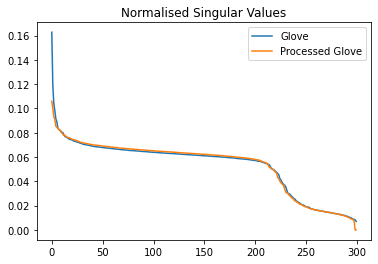

In [11]:
plt.plot(singular1[0], label="Glove")
plt.plot(singular2[0], label="Processed Glove")
plt.legend()
plt.title("Normalised Singular Values")

## Saving the processed vectors

In [13]:
file_to_write = open("processed_embeddings.npz","wb")
np.savez(file_to_write, words = np.array(words), embeddings = np.array(processed_embedding_matrix))
file_to_write.close()

# Examples from a task
## Similarity task

In [21]:
from web.datasets.similarity import fetch_MEN, fetch_WS353, fetch_SimLex999, fetch_MTurk, fetch_RG65, fetch_RW, fetch_TR9856
import scipy
def evaluate_similarity(w, X, y):
    """
    Calculate Spearman correlation between cosine similarity of the model
    and human rated similarity of word pairs

    Parameters
    ----------
    w : Embedding or dict
      Embedding or dict instance.

    X: array, shape: (n_samples, 2)
      Word pairs

    y: vector, shape: (n_samples,)
      Human ratings

    Returns
    -------
    cor: float
      Spearman correlation
    """
    if isinstance(w, dict):
        w = Embedding.from_dict(w)

    missing_words = 0
    words = w.vocabulary.word_id
    for query in X:
        for query_word in query:
            if query_word not in words:
                missing_words += 1
    if missing_words > 0:
        logger.warning("Missing {} words. Will replace them with mean vector".format(missing_words))


    mean_vector = np.mean(w.vectors, axis=0, keepdims=True)
    A = np.vstack(w.get(word, mean_vector) for word in X[:, 0])
    B = np.vstack(w.get(word, mean_vector) for word in X[:, 1])
    scores = np.array([v1.dot(v2.T)/(np.linalg.norm(v1)*np.linalg.norm(v2)) for v1, v2 in zip(A, B)])
    return scores, scipy.stats.spearmanr(scores, y).correlation

data= fetch_MEN()
scores_glove, _ = evaluate_similarity(glove_embeddings,data.X,data.y)
scores_processed, _ = evaluate_similarity(processed_embeddings,data.X,data.y)


/home/mila/g/gampapha/.conda/envs/nlmatics_2/lib/python3.6/site-packages/ipykernel_launcher.py:38: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/home/mila/g/gampapha/.conda/envs/nlmatics_2/lib/python3.6/site-packages/ipykernel_launcher.py:39: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


### Glove vectors

In [34]:
import pandas as pd

df1 = pd.DataFrame()
num_words = 20
min_ten = np.argsort(scores_glove)[:num_words]
max_ten= np.argsort(scores_glove)[-num_words:]

df1["min_k_scores"] = pd.Series(scores_glove[min_ten])
df1["min_k_words"] = pd.Series(["<->".join((a[0],a[1])) for a in data.X[min_ten]])
df1["min_k_true"] = pd.Series([a[0] for a in data.y[min_ten]])
df1["max_k_scores"] = pd.Series(scores_glove[max_ten])
df1["max_k_words"] = pd.Series(["<->".join((a[0],a[1])) for a in data.X[max_ten]])
df1["max_k_true"] = pd.Series([a[0] for a in data.y[max_ten]])
df1

,min_k_scores,min_k_words,min_k_true,max_k_scores,max_k_words,max_k_true
0,-0.144221,construction<->violet,0.6,0.721251,dinner<->lunch,7.4
1,-0.127091,carrot<->city,1.0,0.721868,breakfast<->dinner,7.4
2,-0.126579,people<->stair,4.2,0.724834,autumn<->spring,8.8
3,-0.123640,jellyfish<->rally,0.4,0.725456,rail<->railway,8.6
4,-0.122103,bay<->chipmunk,1.4,0.727916,game<->play,6.4
5,-0.119800,bracelet<->mountain,0.8,0.729003,aircraft<->airplane,9.2
6,-0.117212,lego<->weather,0.8,0.732590,cafe<->restaurant,8.4
7,-0.114480,explosion<->stencil,0.6,0.745041,shop<->store,7.8
8,-0.108955,graveyard<->silver,3.0,0.752356,cattle<->sheep,7.6
9,-0.108011,clown<->flood,1.2,0.761904,evening<->night,8.4


### Processed Vectors

In [36]:
df2 = pd.DataFrame()
num_words = 20
min_ten = np.argsort(scores_processed)[:num_words]
max_ten= np.argsort(scores_processed)[-num_words:]

df2["min_k_scores"] = pd.Series(scores_processed[min_ten])
df2["min_k_words"] = pd.Series(["<->".join((a[0],a[1])) for a in data.X[min_ten]])
df2["min_k_true"] = pd.Series([a[0] for a in data.y[min_ten]])
df2["max_k_scores"] = pd.Series(scores_processed[max_ten])
df2["max_k_words"] = pd.Series(["<->".join((a[0],a[1])) for a in data.X[max_ten]])
df2["max_k_true"] = pd.Series([a[0] for a in data.y[max_ten]])
df2

,min_k_scores,min_k_words,min_k_true,max_k_scores,max_k_words,max_k_true
0,-0.123695,carrot<->city,1.0,0.718475,town<->village,8.6
1,-0.116446,construction<->violet,0.6,0.726054,dinner<->lunch,7.4
2,-0.109061,jellyfish<->rally,0.4,0.727312,breakfast<->dinner,7.4
3,-0.107640,bracelet<->mountain,0.8,0.731430,rail<->railway,8.6
4,-0.102209,people<->stair,4.2,0.737399,autumn<->spring,8.8
5,-0.094024,skating<->sticker,2.2,0.737639,aircraft<->airplane,9.2
6,-0.093932,lego<->weather,0.8,0.743298,cafe<->restaurant,8.4
7,-0.090030,daisy<->gravestone,4.6,0.748254,shop<->store,7.8
8,-0.088359,origami<->stadium,1.2,0.753521,daughter<->son,8.2
9,-0.082827,graveyard<->silver,3.0,0.755752,cattle<->sheep,7.6


- The proccessed vectors improved upon the glove vectors relatively. For eg, aircraft <-> airplane has a true score of 9.2 , processed vectors have a score of 0.737639 > 0.729003 (by glove). 
- And on few pairs like daughter <-> mother processed vectors have score 0.810065 closer to the true score 8.0 compared to the high score of 0.831060 by glove vectors.
- In this way, processed vectors have better overall score on this similarity task

## Analogy Task

In [37]:
from web.analogy import *
def evaluate_analogy(w, X, y, method="add", k=None, category=None, batch_size=100):
    """
    Simple method to score embedding using SimpleAnalogySolver

    Parameters
    ----------
    w : Embedding or dict
      Embedding or dict instance.

    method : {"add", "mul"}
      Method to use when finding analogy answer, see "Improving Distributional Similarity
      with Lessons Learned from Word Embeddings"

    X : array-like, shape (n_samples, 3)
      Analogy questions.

    y : array-like, shape (n_samples, )
      Analogy answers.

    k : int, default: None
      If not None will select k top most frequent words from embedding

    batch_size : int, default: 100
      Increase to increase memory consumption and decrease running time

    category : list, default: None
      Category of each example, if passed function returns accuracy per category
      in addition to the overall performance.
      Analogy datasets have "category" field that can be supplied here.

    Returns
    -------
    result: dict
      Results, where each key is for given category and special empty key "" stores
      summarized accuracy across categories
    """
    if isinstance(w, dict):
        w = Embedding.from_dict(w)

    assert category is None or len(category) == y.shape[0], "Passed incorrect category list"

    solver = SimpleAnalogySolver(w=w, method=method, batch_size=batch_size, k=k)
    y_pred = solver.predict(X)

    if category is not None:
        results = OrderedDict({"all": np.mean(y_pred == y)})
        count = OrderedDict({"all": len(y_pred)})
        correct = OrderedDict({"all": np.sum(y_pred == y)})
        for cat in set(category):
            results[cat] = np.mean(y_pred[category == cat] == y[category == cat])
            count[cat] = np.sum(category == cat)
            correct[cat] = np.sum(y_pred[category == cat] == y[category == cat])

        return pd.concat([pd.Series(results, name="accuracy"),
                          pd.Series(correct, name="correct"),
                          pd.Series(count, name="count")],
                         axis=1)
    else:
        return y_pred, np.mean(y_pred == y)

    
data= fetch_google_analogy()

scores_glove, _ = evaluate_analogy(glove_embeddings,data.X,data.y)
scores_processed, _ = evaluate_analogy(processed_embeddings,data.X,data.y)



/home/mila/g/gampapha/nlmatics_2/nlmatics/web/analogy.py:105: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  A, B, C = np.vstack(w.get(word, mean_vector) for word in X_b[:, 0]), \
/home/mila/g/gampapha/nlmatics_2/nlmatics/web/analogy.py:106: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  np.vstack(w.get(word, mean_vector) for word in X_b[:, 1]), \
/home/mila/g/gampapha/nlmatics_2/nlmatics/web/analogy.py:107: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  np.vstack(w.get(word, mean_vector)

### Glove Vectors

In [44]:
import pandas as pd

df1 = pd.DataFrame()
num_words = 30
indexes = np.random.choice(len(data.X),num_words, replace=False)

df1["Analogy"] = pd.Series([ "::".join((a[0]+"<->"+a[1],a[2] + "<-> ??")) for a in data.X[indexes]])
df1["True"] = pd.Series(data.y[indexes])
df1["Predicted"] = pd.Series(scores_glove[indexes])


df1

,Analogy,True,Predicted
0,moving<->moved::hiding<-> ??,hid,fled
1,weak<->weaker::small<-> ??,smaller,smaller
2,vilnius<->lithuania::ankara<-> ??,turkey,turkey
3,sit<->sits::provide<-> ??,provides,provides
4,dancing<->danced::increasing<-> ??,increased,increased
5,generate<->generates::talk<-> ??,talks,radio
6,fast<->faster::tall<-> ??,taller,taller
7,listen<->listening::write<-> ??,writing,writing
8,hanoi<->vietnam::bangkok<-> ??,thailand,thailand
9,cat<->cats::lion<-> ??,lions,lions


### Processed Vectors

In [45]:
df2 = pd.DataFrame()

df2["Analogy"] = pd.Series([ "::".join((a[0]+"<->"+a[1],a[2] + "<-> ??")) for a in data.X[indexes]])
df2["True"] = pd.Series(data.y[indexes])
df2["Predicted"] = pd.Series(scores_processed[indexes])
df2

,Analogy,True,Predicted
0,moving<->moved::hiding<-> ??,hid,non-institutionalized
1,weak<->weaker::small<-> ??,smaller,smaller
2,vilnius<->lithuania::ankara<-> ??,turkey,turkey
3,sit<->sits::provide<-> ??,provides,provides
4,dancing<->danced::increasing<-> ??,increased,increased
5,generate<->generates::talk<-> ??,talks,hears
6,fast<->faster::tall<-> ??,taller,taller
7,listen<->listening::write<-> ??,writing,writing
8,hanoi<->vietnam::bangkok<-> ??,thailand,thailand
9,cat<->cats::lion<-> ??,lions,lions
